# Context


The increasing usage of electric vehicles (EVs) highlights the need to predict EV charging station duration. Accurate predictions are crucial for better management of charging infrastructure, optimizing utilization, minimizing user wait times, improving grid stability by managing peak demand, and enabling efficient fleet operations. These efforts contribute to a smoother transition to electric vehicles by addressing concerns around range anxiety and charging accessibility.

### What are we going to perform on this notebook?





*   For this we will make use of a dataset available at https://www.kaggle.com/code/anshtanwar/ev-charging-duration
*   Handle outliers using the IsolationForest algorithm and standardize features (El_kWh and Duration_hours) using StandardScaler.
*   Split the dataset into training and testing sets to evaluate model performance on unseen data.
*    Train regression models (RandomForestRegressor and DecisionTreeRegressor) to predict Duration_hours based on input features.
*    Assess model performance using metrics such as Root Mean Squared Error (RMSE).
*    Create visualizations to analyze feature distributions, outlier removal results, feature importance, and actual vs. predicted values for better interpretability and insights.




## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">1. Import Libraries</div>

In [ ]:
!pip install ydata_profiling

In [ ]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")


Before I start, I use pd.read_csv to convert dataset in dataframe

In [ ]:
df = pd.read_csv('df1_traffic_weather.csv')

In [ ]:
df.shape

(6878, 56)

In [ ]:
df.head(3)

,Unnamed: 0,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
0,0,1,AdO3,AdO3-4,Private,NaN,2018-12-21 10:00:00,10,21.12.2018 10:23,10.0,...,1,81,547,70,35,-0.5,1545346800,176,12.0,2.4
1,1,2,AdO3,AdO3-4,Private,NaN,2018-12-21 10:00:00,10,21.12.2018 10:32,10.0,...,1,81,547,70,35,-0.5,1545346800,176,12.0,2.4
2,2,3,AdO3,AdO3-4,Private,NaN,2018-12-21 11:00:00,11,21.12.2018 19:46,19.0,...,1,81,547,70,35,-0.5,1545346800,176,12.0,2.4


In [ ]:
df.columns

Index(['Unnamed: 0', 'session_ID', 'Garage_ID', 'User_ID', 'User_type',
       'Shared_ID', 'Start_plugin', 'Start_plugin_hour', 'End_plugout',
       'End_plugout_hour', 'El_kWh', 'Duration_hours', 'month_plugin',
       'weekdays_plugin', 'Plugin_category', 'Duration_category',
       'KROPPAN BRU', 'MOHOLTLIA', 'SELSBAKK', 'MOHOLT RAMPE 2',
       'Jonsvannsveien vest for Steinanvegen', 'Start_plugin_date', 'clouds',
       'dewpt', 'dhi', 'dni', 'ghi', 'max_dhi', 'max_dni', 'max_ghi',
       'max_temp', 'max_temp_ts', 'max_uv', 'max_wind_dir', 'max_wind_spd',
       'max_wind_spd_ts', 'min_temp', 'min_temp_ts', 'precip', 'precip_gpm',
       'pres', 'revision_status', 'rh', 'slp', 'snow', 'snow_depth',
       'solar_rad', 't_dhi', 't_dni', 't_ghi', 't_solar_rad', 'temp', 'ts',
       'wind_dir', 'wind_gust_spd', 'wind_spd'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 56 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            6878 non-null   int64  
 1   session_ID                            6878 non-null   int64  
 2   Garage_ID                             6878 non-null   object 
 3   User_ID                               6878 non-null   object 
 4   User_type                             6878 non-null   object 
 5   Shared_ID                             1412 non-null   object 
 6   Start_plugin                          6878 non-null   object 
 7   Start_plugin_hour                     6878 non-null   int64  
 8   End_plugout                           6844 non-null   object 
 9   End_plugout_hour                      6844 non-null   float64
 10  El_kWh                                6878 non-null   object 
 11  Duration_hours   

In [ ]:
# Look at the balance of El_kWh
df['El_kWh'].value_counts()

,count
El_kWh,
"0,01",26
"0,02",16
"0,03",14
"3,92",11
"6,63",11
...,...
"28,74",1
"26,31",1
"28,9",1


In [ ]:
# Look at the balance of Duration hour
df['Duration_hours'].value_counts()

,count
Duration_hours,
"0,014722222",5
"0,663055556",4
"0,010833333",4
"4,054166667",3
"4,136111111",3
...,...
"4,363888889",1
"5,3675",1
"1,007777778",1


# Machine Learning Implementation
* Balance data
* Feature Scaling
* Create Train/Validation Splits
* Create Models
* Compare Results

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [ ]:
# El_kWh -> electric usage
df = df.drop(['snow_depth','revision_status','End_plugout',"Start_plugin_date"],axis=1)
df['El_kWh'] = df['El_kWh'].str.replace(',', '').astype(float)  # Convert to numerical
df['Duration_hours'] = df['Duration_hours'].str.replace(',', '').astype(float)  # Convert to numerical

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['User_type','KROPPAN BRU', 'MOHOLTLIA', 'SELSBAKK','Garage_ID', 'User_ID', 'Shared_ID', 'month_plugin', 'weekdays_plugin', 'Plugin_category', 'Duration_category'])

In [ ]:
df.dropna(inplace=True)

In [ ]:
df

,Unnamed: 0,session_ID,Start_plugin,Start_plugin_hour,End_plugout_hour,El_kWh,Duration_hours,MOHOLT RAMPE 2,Jonsvannsveien vest for Steinanvegen,clouds,...,Plugin_category_late evening (21-midnight),Plugin_category_late morning (9-12),Plugin_category_late night (3-6),Duration_category_Between 12 and 15 hours,Duration_category_Between 15 and 18 hours,Duration_category_Between 3 and 6 hours,Duration_category_Between 6 and 9 hours,Duration_category_Between 9 and 12 hours,Duration_category_Less than 3 hours,Duration_category_More than 18 hours
0,0,1,2018-12-21 10:00:00,10,10.0,3.0,5.000000e+00,194,622,55,...,False,True,False,False,False,False,False,False,True,False
1,1,2,2018-12-21 10:00:00,10,10.0,87.0,1.366667e+08,194,622,55,...,False,True,False,False,False,False,False,False,True,False
2,2,3,2018-12-21 11:00:00,11,19.0,2987.0,8.216389e+09,230,771,55,...,False,True,False,False,False,False,True,False,False,False
3,3,4,2018-12-22 16:00:00,16,16.0,1556.0,2.441972e+09,224,694,61,...,False,False,False,False,False,False,False,False,False,True
4,4,5,2018-12-24 22:00:00,22,23.0,362.0,9.705556e+08,83,353,100,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6873,6873,6874,2020-01-31 17:00:00,17,22.0,1343.0,4.530000e+02,172,769,83,...,False,False,False,False,False,True,False,False,False,False
6874,6874,6875,2020-01-31 18:00:00,18,21.0,91.0,3.182222e+09,159,609,83,...,False,False,False,False,False,True,False,False,False,False
6875,6875,6876,2020-01-31 19:00:00,19,20.0,428.0,1.203889e+09,163,464,83,...,False,False,False,False,False,False,False,False,True,False
6876,6876,6877,2020-01-31 19:00:00,19,19.0,231.0,3.525000e+03,163,464,83,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# Look at the balance of El_kWh
df['El_kWh'].value_counts()

,count
El_kWh,
1.0,31
2.0,22
3.0,19
6.0,15
264.0,12
...,...
3048.0,1
2542.0,1
1555.0,1


In [ ]:
# Look at the balance of duration hours
df['Duration_hours'].value_counts()

,count
Duration_hours,
1.472222e+07,5
1.083333e+07,4
6.630556e+08,4
3.558889e+09,3
1.700000e+01,3
...,...
6.615417e+09,1
1.639444e+09,1
1.225417e+09,1


## Create Train/Test Splits

In [ ]:
# Handle outliers using Isolation Forest
outlier_detector = IsolationForest(contamination=0.05)  # Adjust the contamination parameter
df['outlier'] = outlier_detector.fit_predict(df[['El_kWh', 'Duration_hours']])

# Remove outliers
df = df[df['outlier'] != -1]

# Feature Scaling
scaler = StandardScaler()
df[['El_kWh', 'Duration_hours']] = scaler.fit_transform(df[['El_kWh', 'Duration_hours']])

# Balanced data
X_balanced = df.drop(columns=['Duration_hours','session_ID','Start_plugin', 'Start_plugin_hour', 'End_plugout_hour'])  # All columns except Duration_hours
y_balanced = df['Duration_hours']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

## Create models

In [ ]:
# Since `Duration_hours` is continuous, use regression models instead
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

# Train RandomForest Regressor
rf_model_balanced = RandomForestRegressor(random_state=0).fit(X_train, y_train)

# Train DecisionTree Regressor
dt_model_balanced = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)

# Train Ridge
rr_model_balanced = Ridge(random_state=0).fit(X_train, y_train)

# Evaluate models
rf_predictions = rf_model_balanced.predict(X_test)
dt_predictions = dt_model_balanced.predict(X_test)
rr_predictions = rr_model_balanced.predict(X_test)

## Evaluation

In [ ]:
# Example evaluation metrics
from sklearn.metrics import mean_squared_error

rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
dt_rmse = mean_squared_error(y_test, dt_predictions, squared=False)
rr_rmse = mean_squared_error(y_test, rr_predictions, squared=False)

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Decision Tree RMSE: {dt_rmse}")
print(f"Ridge RMSE: {rr_rmse}")

Random Forest RMSE: 0.7339410847904104
Decision Tree RMSE: 0.9059369489918845
Ridge RMSE: 0.8026925277275173


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, mean_squared_error

# Convert y_test to binary if it's not already (using threshold 0.5)
y_test_bin = (y_test > 0.5).astype(int)

# For classification metrics, convert predictions to binary labels if they are probabilities
rf_pred_bin = (rf_predictions > 0.5).astype(int)  # Binary predictions for Random Forest
dt_pred_bin = (dt_predictions > 0.5).astype(int)  # Binary predictions for Decision Tree

# Calculate classification metrics for Random Forest
rf_accuracy = accuracy_score(y_test_bin, rf_pred_bin)
rf_roc_auc = roc_auc_score(y_test_bin, rf_predictions)  # Use probabilities for ROC AUC
rf_precision = precision_score(y_test_bin, rf_pred_bin)
rf_f1 = f1_score(y_test_bin, rf_pred_bin)

# Calculate classification metrics for Decision Tree
dt_accuracy = accuracy_score(y_test_bin, dt_pred_bin)
dt_roc_auc = roc_auc_score(y_test_bin, dt_predictions)  # Use probabilities for ROC AUC
dt_precision = precision_score(y_test_bin, dt_pred_bin)
dt_f1 = f1_score(y_test_bin, dt_pred_bin)

# Print all metrics
print(f"Random Forest Accuracy: {rf_accuracy:.3f}")
print(f"Random Forest ROC AUC: {rf_roc_auc:.3f}")
print(f"Random Forest Precision: {rf_precision:.3f}")
print(f"Random Forest F1 Score: {rf_f1:.3f}")
print()
print(f"Decision Tree Accuracy: {dt_accuracy:.3f}")
print(f"Decision Tree ROC AUC: {dt_roc_auc:.3f}")
print(f"Decision Tree Precision: {dt_precision:.3f}")
print(f"Decision Tree F1 Score: {dt_f1:.3f}")

Random Forest Accuracy: 0.885
Random Forest ROC AUC: 0.908
Random Forest Precision: 0.711
Random Forest F1 Score: 0.702

Decision Tree Accuracy: 0.879
Decision Tree ROC AUC: 0.841
Decision Tree Precision: 0.695
Decision Tree F1 Score: 0.687


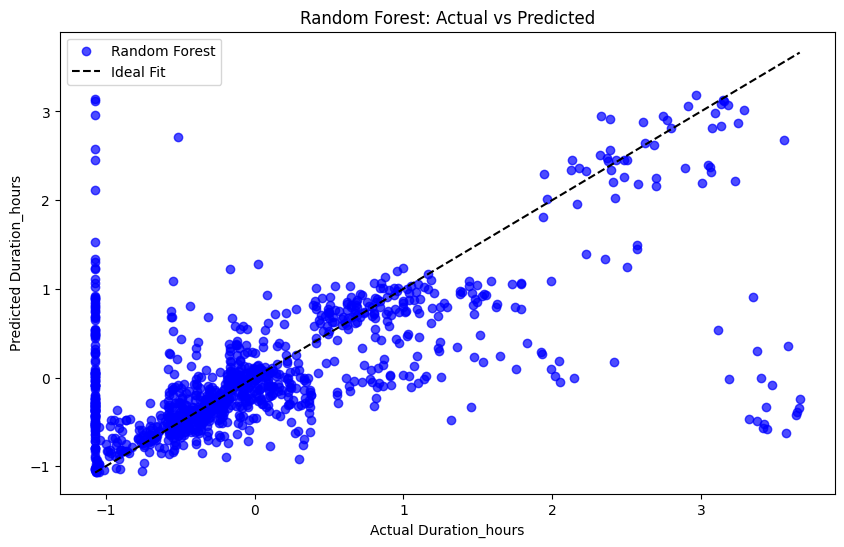

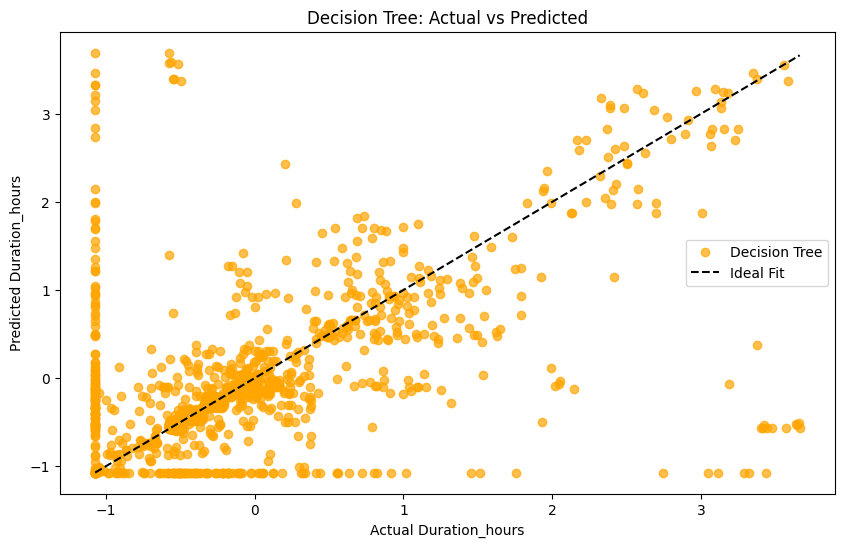

In [ ]:
from matplotlib import pyplot as plt
# Random Forest: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, label='Random Forest', alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black', label='Ideal Fit')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Duration_hours')
plt.ylabel('Predicted Duration_hours')
plt.legend()
plt.show()

# Decision Tree: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, dt_predictions, label='Decision Tree', alpha=0.7, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black', label='Ideal Fit')
plt.title('Decision Tree: Actual vs Predicted')
plt.xlabel('Actual Duration_hours')
plt.ylabel('Predicted Duration_hours')
plt.legend()
plt.show()